In [1]:
import torch
import scanpy as sc
import anndata as ad
import celldiffusion as cd


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
if device == 'cuda':
    print(torch.cuda.get_device_name())

cuda
NVIDIA L40S


In [3]:
DATA_PATH = '/projectnb/czlab/A00/ycliu/scRNA_integration_benchmark_datasets/PBMC23K/'

OUTPUT_PATH = 'outputs/'


# Load dataset

In [4]:
adata = sc.read_h5ad(DATA_PATH + 'pbmc23k.h5ad')

adata

AnnData object with n_obs × n_vars = 23589 × 20729
    obs: 'batch', 'labels'
    var: 'gene_ids', 'gene_symbols', 'feature_types'

# Preprocess

/usr2/postdoc/ycliu137/.conda/envs/diffusion_env/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:251: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)


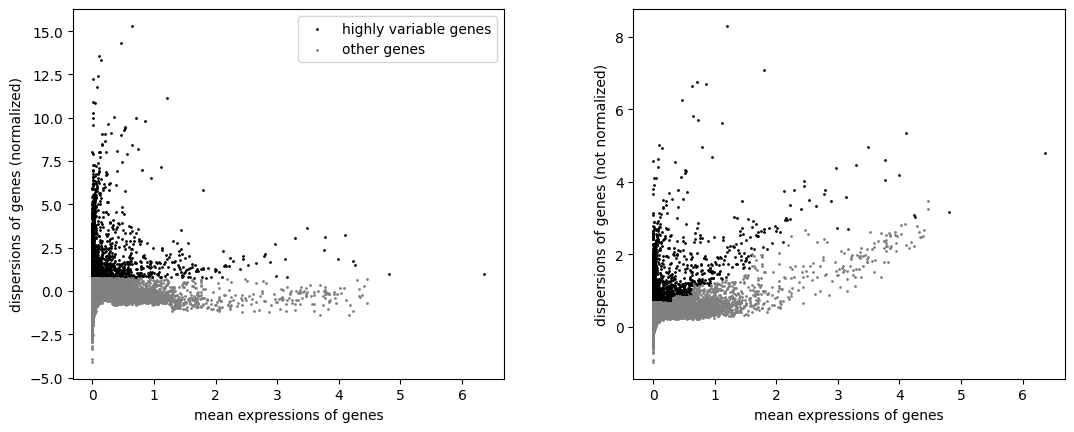

In [5]:
sc.pp.filter_genes(adata, min_cells=3)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, n_top_genes =2000, min_mean=0.0125, max_mean=9, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [6]:
adata.raw = adata.copy()
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 23589 × 2000
    obs: 'batch', 'labels'
    var: 'gene_ids', 'gene_symbols', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

# Feature encoder

In [7]:
cd.encode_features(adata, 
                   D_encode_list=[2000, 300, 50], # Encoder dimension in each layer
                   D_decode_list=[50, 300, 2000], # Decoder dimension in each layer
                   max_epoch=2000, # number of epoch
                   lr=1e-3,        # learning rate
                   device=device)


2025-07-21 15:04:37,670 - --------> Starting feature encoder ...
/projectnb/czproj/Algorithms/ycliu/Pan_proj/diffusion/feature_encoder.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_1 = torch.tensor(feature_matrix.to(device), dtype = feature_matrix_recover.dtype)
2025-07-21 15:04:39,629 - ------------------------> Epoch: 1/2000, Current loss: 14736243.0000
2025-07-21 15:04:41,424 - ------------------------> Epoch: 51/2000, Current loss: 3151418.5000
2025-07-21 15:04:43,205 - ------------------------> Epoch: 101/2000, Current loss: 2745604.7500
2025-07-21 15:04:44,984 - ------------------------> Epoch: 151/2000, Current loss: 2612713.0000
2025-07-21 15:04:46,764 - ------------------------> Epoch: 201/2000, Current loss: 2523008.5000
2025-07-21 15:04:48,544 - ------------------------> Epoch: 251/2000, Current loss: 2444275.00

# Integration

In [8]:
# Build the diffusion graph for data intagration

cd.inte.build_integration_graph(adata, 
                            batch_key='batch', # get batch labels
                            use_rep='X_fae',   # The same as 'use_rep' in Scanpy. Choosing cell embeddings.
                            n_edges_per_node=50, # Number of outgoing edges of each node in the diffusion graph.
                            k_mnn=50,      # K for KNNs that toward finding MNNs.
                            device=device)

In [9]:
# Build the input KNN adjacencies for each batch, which is used in loss function.

cd.inte.build_integration_loss_adj(adata, 
                                   use_rep='X_fae', # The same as 'use_rep' in Scanpy. Choosing cell embeddings.
                                   k=50,            # K for building KNN graph
                                   device=device)

In [10]:
cd.inte.integration_diffusion(adata, 
                              use_rep='X_fae', # The same as 'use_rep' in Scanpy. Choosing cell embeddings.
                              max_epoch=2000,  # The number of training epoch
                              lr=1e-3,         # Learning rate
                              time_increment_diffusion=0.2, # Suggested value==0.2 when using 8 diffusion layers.
                              device=device)


2025-07-21 15:06:24,110 - --------> Starting data integration ...
/projectnb/czproj/Algorithms/ycliu/Pan_proj/sc_integration/integration_DIF.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_now = torch.tensor(adjacency_list[ii].to(device), dtype = recon_adj_list[ii].dtype)
2025-07-21 15:06:24,428 - ------------------------> Epoch: 1/2000, Current loss: 10598672384.0000
2025-07-21 15:06:37,752 - ------------------------> Epoch: 51/2000, Current loss: 160581888.0000
2025-07-21 15:06:51,074 - ------------------------> Epoch: 101/2000, Current loss: 139642768.0000
2025-07-21 15:07:04,400 - ------------------------> Epoch: 151/2000, Current loss: 134734848.0000
2025-07-21 15:07:17,725 - ------------------------> Epoch: 201/2000, Current loss: 132603424.0000
2025-07-21 15:07:31,054 - ------------------------> Epoch: 251/2000, Curr

## View integrated embeddings

In [11]:
sc.pp.neighbors(adata, use_rep='X_dif', n_neighbors=50, n_pcs=50)
sc.tl.umap(adata)

/usr2/postdoc/ycliu137/.conda/envs/diffusion_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


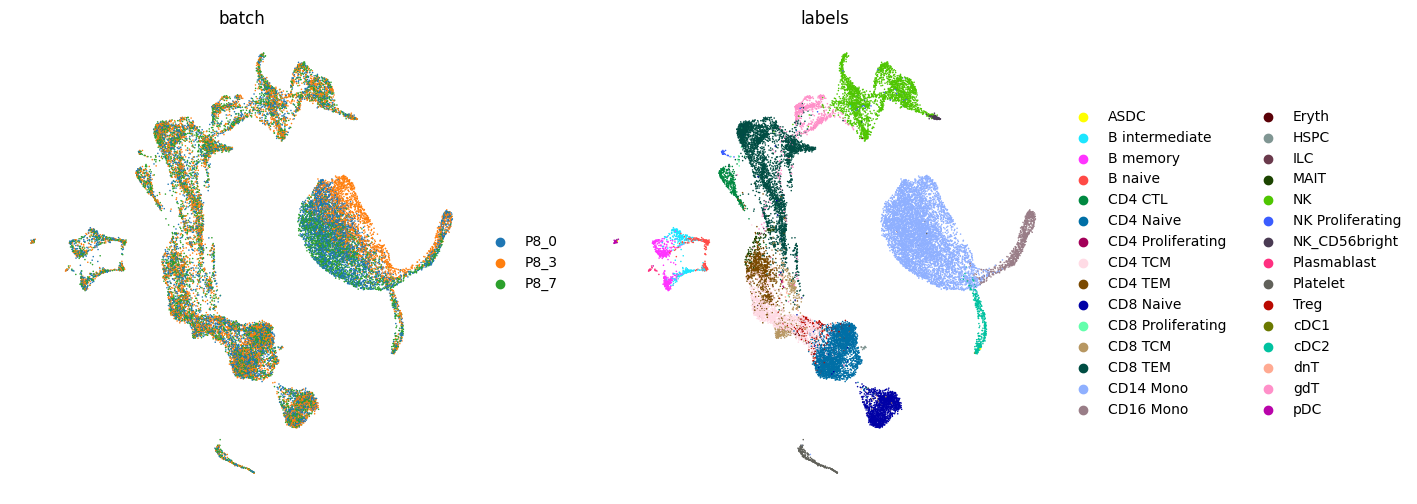

In [12]:
from matplotlib import rcParams
FIGSIZE = (6, 6)
rcParams["figure.figsize"] = FIGSIZE

sc.pl.umap(adata, color=['batch', 'labels'], frameon=False, size=5, ncols=2)

# Save integrated data

In [13]:
adata.write(OUTPUT_PATH + 'scDiffusion_integration.h5ad')

In [14]:
adata = ad.read_h5ad(OUTPUT_PATH + 'scDiffusion_integration.h5ad')
